# Demo: Preparing and Exploring Image Data

In [178]:
# Now that we understand how convolutional layers and pooling layers work,
# let's set up our first convolutional neural network to classify images.
# We'll work with the MNIST dataset that we've seen before.
# We'll work on  this notebook where we first set up our convolutional neural network.
# We'll then perform some hyperparameter tuning to see how the model changes as we change its design.

In [179]:
# Set up the import statements for the PyTorch and other data science libraries that we might need.

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

import torch
import torchvision

In [180]:
# Let's read in the MNIST data that we've worked with before.
# This data is available in the form of CSV files.

mnist_train = pd.read_csv('datasets/mnist-in-csv/mnist_train.csv')
mnist_test = pd.read_csv('datasets/mnist-in-csv/mnist_test.csv')

In [181]:
# If you remember, these are grayscale 28 x 28 images.
# Every row in this dataset corresponds to a single image along with its label.

mnist_train.head()

,label,1x1,1x2,1x3,1x4,1x5,1x6,1x7,1x8,1x9,...,28x19,28x20,28x21,28x22,28x23,28x24,28x25,28x26,28x27,28x28
0,5,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,4,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,9,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [182]:
display(mnist_train.shape)
display(mnist_test.shape)

(60000, 785)

(10000, 785)

In [183]:
# We'll clean up our data first.
# Let's drop all records which we have missing fields using dropna.

mnist_train = mnist_train.dropna()
mnist_test = mnist_test.dropna()

In [184]:
display(mnist_train.shape)
display(mnist_test.shape)

(60000, 785)

(10000, 785)

In [185]:
# We've seen these images before,
# but let's just explore our data before we work with it.
# I'm going to choose eight images at random to display and view.
# These are eight records from our CSV file,
# and you can see that each record has 785 columns.

random_sel = mnist_train.sample(8)
random_sel.shape

(8, 785)

In [186]:
# I'm going to go ahead and drop the label column because we're only
# interested in the image features of this batch.

image_features = random_sel.drop('label', axis=1) # drop 'label' column

# If you remember, the pixel intensity values were represented using integers from 0 to 255.
# I'm going to convert this to a 0-1 scale by dividing every pixel by 255 (min-max normalization)
# and that'll convert the result to a torch.Tensor.


# In addition, I've also reshaped the images to be 28 x 28 images so that they can be displayed in matplotlib.
# One shape dimension can be -1. In this case, the value is inferred from the length of the array and 
# remaining dimensions.
image_batch = (torch.Tensor(image_features.values / 255.)).reshape(-1, 28, 28)

# We have eight images in our batch here, and every image is 28 x 28 pixels.
image_batch.shape

torch.Size([8, 28, 28])

In [187]:
# Let's make a grid using torchvision.utils.make_grid(), and here is our grid shape.
# .unsqueeze(1) is used to add an additional dimension, which is generally used for the channel. 
# Since the images are grayscale, they don't have a channel dimension, and .unsqueeze(1) adds that. 
# After this operation, the shape of new object representing batch of images (image_batch.unsqueeze(1)) 
# becomes [8, 1, 28, 28].
# nrow=8 specifies that there should be 8 images in each row of the grid.
grid = torchvision.utils.make_grid(image_batch.unsqueeze(1), nrow=8)

# Observe that the make_grid utility converts our images to multi-channel or three-channel RGB images.
# Now we are just doing it for this batch of eight images so that we can 
# display it because we've used the make_grid utility.
# When we work with the images to feed into our CNN,
# we'll work with them as single-channel grayscale images.
grid.shape


# The output tensor `grid` has a shape of `[3, 32, 242]` due to the default behavior of 
# `torchvision.utils.make_grid`:

# 1. **Number of Channels**: The first dimension is 3 because `make_grid` by default converts 
# the images to have 3 channels (RGB) to create the grid image. 
# Even though the input images are grayscale (1 channel), the grid is created as an RGB image.

# 2. **Height**: The second dimension is 32 because each input image has a height of 28, and 
# there is a padding of 2 pixels added by default to both top and bottom of each image. 
# So, 28 + 2 (top padding) + 2 (bottom padding) = 32.

# 3. **Width**: The third dimension is 242 because each image has a width of 28, 
# there are 8 images in a row (`nrow=8`), and by default, 
# there is a padding of 2 pixels between each image as well as at the beginning and end of the row. 
# So, (28 * 8) + 2 (beginning padding) + 2 * 7 (padding between images) + 2 (end padding) = 242.

# This output tensor represents an RGB image of the grid. 
# The height and width are slightly more than the dimensions of the 
# individual images due to the padding added between the images and on the borders.

torch.Size([3, 32, 242])

(-0.5, 241.5, 31.5, -0.5)

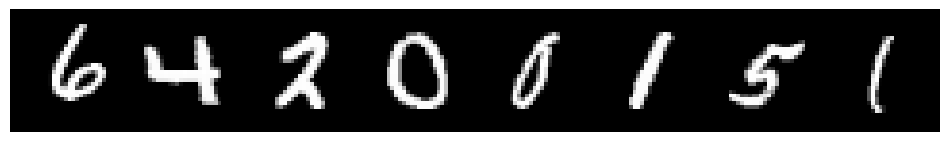

In [188]:
# Now let's move the channel information to be the last dimension by using the transpose method.
# This is because matplotlib expects our images to have
# channel information in the last dimension.
# Let's go ahead and take a look at the images that we're going to work with.
# Here are eight images from our sample.

plt.figure(figsize=(12, 12))
plt.imshow(grid.numpy().transpose((1, 2, 0)))
plt.axis('off')

In [189]:
# The next few operations that I'm about to perform are familiar to us,
# so I'm going to run through them quickly.
# We extract the training features, that is the image pixel intensities and the
# corresponding labels into separate tensors.
# We do this for both the training data, as well as the test data.

mnist_train_features = mnist_train.drop('label', axis=1)
mnist_train_target = mnist_train['label']

mnist_test_features = mnist_test.drop('label', axis=1)
mnist_test_target = mnist_test['label']

In [190]:
# We then convert all of the image data and the corresponding labels to torch.tensors.
# Images are of type float, the labels are of type long.


X_train_tensor = torch.tensor(mnist_train_features.values, dtype=torch.float)
Y_train_tensor = torch.tensor(mnist_train_target.values, dtype=torch.long)

x_test_tensor = torch.tensor(mnist_test_features.values, dtype=torch.float)
y_test_tensor = torch.tensor(mnist_test_target.values, dtype=torch.long)

In [191]:
# Before we move on, let's quickly print out the shape of the training and test image data,
# as well as the corresponding labels.
# There are 60000 images in the training data and 10000 in the test data.
print(X_train_tensor.shape)
print(Y_train_tensor.shape)
print(x_test_tensor.shape)
print(y_test_tensor.shape)

torch.Size([60000, 784])
torch.Size([60000])
torch.Size([10000, 784])
torch.Size([10000])


In [192]:
# Remember that convolutional neural networks are
# built to mimic the visual cortex,
# which means it views images in the original two dimensions; height and width.
# In addition, CNNs in PyTorch expect images to be fed in batches,
# and also expect channel information to be one of the dimensions.
# This is why we need to reshape the images in our training and
# test data to be in four-dimensional form.

X_train_tensor = X_train_tensor.reshape(-1, 1, 28, 28)
x_test_tensor = x_test_tensor.reshape(-1, 1, 28, 28)

# The first dimension is the batch. Here the first dimension is -1 (it means - inferred from the other dimensions)
# It'll correspond to the number of images that we have to work with,
# and the remaining three dimensions refer to a single image.
# Each image is a 28 x 28 grayscale image.
# Let's take a look at the shape of our training and test data after we've performed this reshape.
# You can see that we have 60000 images, and each image is 28 x 28 x 1.
# This is in the training data, 
# and we have 10000 images in the same format in the test data.
print(X_train_tensor.shape)
print(Y_train_tensor.shape)
print(x_test_tensor.shape)
print(y_test_tensor.shape)

torch.Size([60000, 1, 28, 28])
torch.Size([60000])
torch.Size([10000, 1, 28, 28])
torch.Size([10000])


# Demo: Setting up a Convolutional Neural Network

In [193]:
# Now ready to set up our convolutional neural network.
# Go ahead and import the PyTorch modules that we'll need.

import torch.nn as nn
import torch.nn.functional as F

In [194]:
# I'll set up a few variables which holds the different size information in our convolutional neural network.
# Let's look at each of these in turn.

# in_size here refers to the number of channels in your input image.
# The MNIST dataset is made up of grayscale images, which is why in_size is 1 here.
# If you're working with RGB images, in_size will be 3.
in_size = 1

# We'll have two convolutional layers in our neural network.
# The first of these will be of size 16, and the second of size 32.
# These refer to the number of feature maps generated by each convolutional layer,
# that is the depth of the output produced by each convolutional layer.
hid1_size = 16
hid2_size = 32

# The output size here refers to the size of the output
# from the final linear layer of our CNN.
# Because we have 10 digits into which the input images can be classified,
# this is equal to 10.
out_size = 10

# This is the convolutional kernel size.
# Both of our convolutional layers will use a square kernel that is 5 x 5.
k_conv_size = 5

In [195]:
# Let's set up our custom neural network,
# which inherits from the nn.Module base class.


class ConvNet(nn.Module):
    # Let's first set up the init method where we initialize the
    # convolutional and pooling layers of our neural network.
    def __init__(self):
        super(ConvNet, self).__init__()
        
        # Observe that we have set up two sequential layers.
        # Each sequential layer is made up of a convolutional layer,
        # batch normalization, ReLU activation, followed by a MaxPool layer.
        self.layer1 = nn.Sequential(
                                   # Here is the first convolutional layer where the input size is
                                   # the number of channels in the input images.
                                   # hid1_size refers to the depth of the output of this convolutional layer.
                                   # This is equal to 16 for this first convolutional layer,
                                   # and this convolutional layer will apply a 5 x 5 kernel to the input images.
                                   # The default horizontal and vertical stride for the convolutional kernel is 1.
                                   nn.Conv2d(in_size, hid1_size, k_conv_size),
                                   # Batch normalization is a technique that is often used to improve the speed,
                                   # performance, and stability of your neural networks.
                                   # Batch normalization is used to 0 center and normalize the output of each
                                   # convolutional layer before the activations that follow.
                                   # This allows your model to learn the optimal scale and
                                   # the mean of the inputs for each layer.
                                   # Neural networks often work better and convert faster in training
                                   # when the inputs to each layer are batch normalized,
                                   # so we apply batch normalization to the output of our convolutional
                                   # layer before we pass into the ReLU activation layer.
                                   # OUTPUT HERE: (28-5 + 0) / 1 + 1 = 24. 24x24
                                   nn.BatchNorm2d(hid1_size), # 24x24
                                   nn.ReLU(), #  24x24
                                   # And the output of this convolutional layer is passed into a MaxPool layer
                                   # where we use a 2 x 2 kernel to subsample the input.
                                   # The default horizontal and vertical stride for a pooling layer
                                   # kernel is equal to the size of the kernel itself,
                                   # which will be 2 here in our example.
                                   nn.MaxPool2d(kernel_size=2)) # 2x2 pooling filter
                                   # OUTPUT after pooling: (24 - 2 + 0) / 2 + 1 = 12. So 12x12.
        
        # After this first combination of a convolutional and a pooling layer,
        # we pass it in to another convolutional and pooling layer.
        # Remember that convolutional layers make your input deeper.
        # The output of the second convolutional layer will have 32 feature maps.
        self.layer2 = nn.Sequential(nn.Conv2d(hid1_size, hid2_size, k_conv_size),
                                    # OUTPUT HERE: (12 - 5 + 0) / 1 + 1 = 8. So 8x8
                                   nn.BatchNorm2d(hid2_size), # 8x8
                                   nn.ReLU(), # 8x8
                                   nn.MaxPool2d(kernel_size=2)) 
                                    # OUTPUT after pooling: (8 - 2 + 0) / 2 + 1 = 4. So 4 x 4. 
        
        # After the two sets of layers performing convolution and pooling,
        # we pass this output into a final linear layer.
        # The size of this linear layer depends on the size of the
        # outputs produced by our previous layers,
        # and it's 512 here based on our input image size and the strides and the
        # kernel size that we have chosen for our convolution,
        # as well as pooling layers.
        # 4 x 4 output image from the last layer, and 32 feature maps, which makes 4 x 4 x 32 = 512.
        self.fc = nn.Linear(512, out_size)
        
        
    # Let's set up the forward function for this neural network,
    # which takes in the input images and applies the convolutional,
    # pooling, and linear layers to the input.
    def forward(self, x):
        # We'll first apply the first layer to our input batch of images,
        # and I'm going to print out the shape of the output so that I can
        # see what the convolution result looks like.
        out = self.layer1(x)
        # print(out.shape)
            
        # The output of the first layer is then passed in to the second layer,
        # and I print out the shape of the output which we get
        # from the second layer as well.
        out = self.layer2(out)
        # print(out.shape)
            
        # Now remember the convolutional and pooling layers
        # act on images in two dimensions, images that have height and width,
        # but when we feed in this information to the linear layer,
        # we'll need to reshape the output that we get from our
        # convolutional and pooling layers.
        # This reshape operation serves to flatten the images that we get in each batch so
        # that every image is represented in the form of a 1D vector.
        out = out.reshape(out.size(0), -1) # keep the batch dimension, flatten other dimensions into one dim
        # I'll print out the shape of these flattened images as well so that
        # you can see how the shape of the image changes as you flow through
        # the convolutional neural network.
        # print(out.shape)
            
            
        # And this output will now be fed into our fully connected layer.
        # Remember we had specified 512 pixels in our fully connected layer.
        # By printing out these output shapes, you'll see how we got 512.
        # So if you're not sure of how many pixels you should have in your linear layer,
        # you can simply leave the linear layer out,
        # print out the shapes at every layer of your convolutional neural network,
        # and once you know the shape of the final output you
        # can then set up your linear layer.
        out = self.fc(out)
        # print(out.shape)
            
            
        # I'm going to train this model using cross entropy loss,
        # which can directly take as input the output of your last linear layer.
        # You can choose to apply the softmax function here if you want to,
        # and that works as well,
        # or you can simply use the output of this last linear layer.
        return out

In [196]:
# Create an instance of this model,
model = ConvNet()

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(device)

# and because I want to train this model using the GPU available,
# I'm going to copy over the model parameters to this coda:0 device
# calling model.to(device) in order to perform this copy.
model.to(device)

cuda:0


ConvNet(
  (layer1): Sequential(
    (0): Conv2d(1, 16, kernel_size=(5, 5), stride=(1, 1))
    (1): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (layer2): Sequential(
    (0): Conv2d(16, 32, kernel_size=(5, 5), stride=(1, 1))
    (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (fc): Linear(in_features=512, out_features=10, bias=True)
)

In [197]:
# In addition to the model parameters,
# you also need to copy over the tensors for the training and
# test images and the corresponding labels,
# and we do this as well using the to() function.

X_train_tensor = X_train_tensor.to(device)
x_test_tensor = x_test_tensor.to(device)

Y_train_tensor = Y_train_tensor.to(device)
y_test_tensor = y_test_tensor.to(device)

# Demo: Training a CNN

In [165]:
# The learning_rate that we'll use to train our
# convolutional neural network is 0.001,
# and the loss function is the CrossEntropyLoss.
learning_rate = 0.001

In [198]:
# We use the CrossEntropyLoss when we apply softmax activation to our linear layer,
# or this can work directly with the output of the linear layer as well.
criterion = nn.CrossEntropyLoss()

In [199]:
# Instantiate an Adam optimizer with our model parameters and
# the learning rate that we have chosen.
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

In [200]:
# We'll train our convolutional neural network for a total of 10 epochs,
# and we'll maintain the loss for each epoch in a list called loss_values.

num_epochs = 10
loss_values = list()

In [201]:
def get_cuda_stats():
    #Additional Info when using cuda
    if device.type == 'cuda':
        print(torch.cuda.get_device_name(0))
        print('Memory Usage:')
        print('Allocated:', round(torch.cuda.memory_allocated(0)/1024**3,1), 'GB')
        print('Cached:   ', round(torch.cuda.memory_reserved(0)/1024**3,1), 'GB')

In [202]:
get_cuda_stats()

Quadro RTX 5000 with Max-Q Design
Memory Usage:
Allocated: 0.2 GB
Cached:    27.9 GB


In [203]:
# We find that the code to train this convolutional neural network is the same
# as the fully connected neural network that we saw before.
# We run a for loop for each epoch, calculate the output of the current model,
# calculate the loss of the actual labels versus the
# predicted labels from our model,
# zero out the gradients for our model by calling optimizer.zero_grad,
# make a backward pass for the neural network,
# and call optimizer.step to update the model parameters.
# I'll then print out and append the value of loss for each epoch.
for epoch in range (1, num_epochs):
    
    outputs = model(X_train_tensor)
    loss = criterion(outputs, Y_train_tensor)
    
    optimizer.zero_grad()
    loss.backward()
    optimizer.step() # update model parameters
    
    print('Epoch - %d, loss - %0.5f '%(epoch, loss.item()))
    loss_values.append(loss.item())
    


# Let's start the training process, and thanks to all of the print statements that we put in
# the forward pass of the neural network,
# you can see how the shape of the data changes as it passes through your various layers.
# You can see that the output of the first layer which contains a
# convolutional layer as well as a pooling layer is the 60000 images that we had in our training data 
# and 16, 12, 12. So how did we get this?
# The first 16 here refers to the depth of the convolutional layer output.
# This convolutional layer outputs 16 feature maps.
# The default padding on the input is 0,
# that means we haven't added any additional padding pixels,
# and the stride of the convolutional kernel is equal to 1 in both the
# horizontal as well as the vertical directions.
# Given that our input images were 28 x 28 images,
# the size of the output convolutional result will be 24 x 24 images
# thanks to our convolutional kernel size of 5.
# When the output of the convolutional layer,
# which are feature maps, 16 feature maps,
# each of size 24 x 24, are passed into the MaxPool layer,
# the output of the MaxPool layer will be 12 pixels by 12 pixels.
# This is because the kernel size of our MaxPool layer is 2 and the stride is 2 by default, 
# both horizonatally and vertically. This will halve the size of the input fed into this MaxPool layer.


# So 12 x 12 inputs will be fed into layer 2,
# and the output of layer 2 will be 4 x 4.
# The depth of the feature maps will change because the convolutional
# layer in layer 2 will output 32 feature maps.
# You can apply the same math that we did before to see how the 12 x 12
# inputs were reduced to 4 x 4 outputs of this layer.


# Now that we know the output of this layer 2,
# you can now see how we calculated the size of the linear layer,
# 32 multiplied by 4 multiplied by 4 gives us 512.
# This fully connected linear layer has an output size of 10 corresponding
# to the 10 digits that images can be classified into.
# And this is an easy, practical way for you to calculate the shape of your output as it passes
# through the layers that you've set up in your neural network.

Epoch - 1, loss - 2.52409 
Epoch - 2, loss - 3.46788 
Epoch - 3, loss - 2.58975 
Epoch - 4, loss - 1.70555 
Epoch - 5, loss - 1.55359 
Epoch - 6, loss - 1.13371 
Epoch - 7, loss - 1.09458 
Epoch - 8, loss - 1.02838 
Epoch - 9, loss - 0.78641 


In [204]:
get_cuda_stats()

Quadro RTX 5000 with Max-Q Design
Memory Usage:
Allocated: 0.2 GB
Cached:    27.9 GB


Text(0, 0.5, 'Loss')

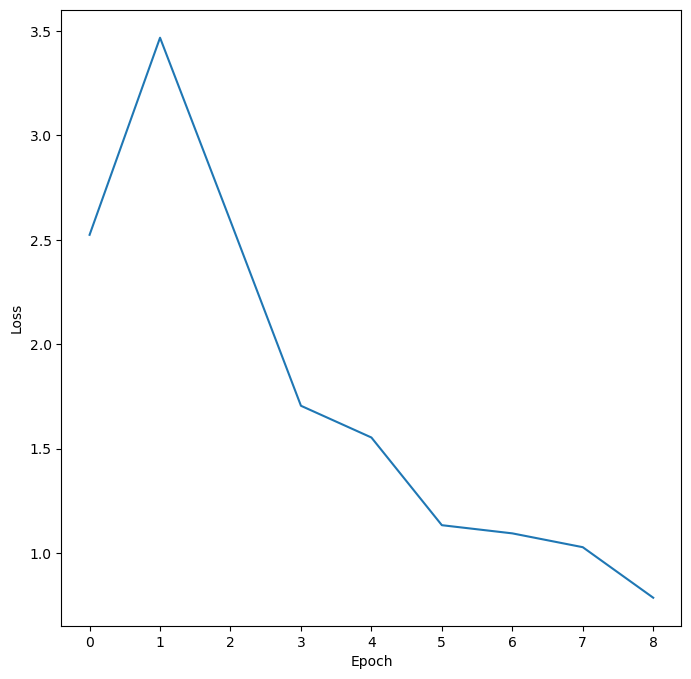

In [205]:
# As we train our neural network,
# we store the loss values for each epoch in a list.
#  Let's plot these loss values to see how the loss
# moved through the training process.
x = range(0, 9)

# We use matplotlib for this,
# and you can see that as we trained our model
# further the loss value fell sharply.
plt.figure(figsize = (8, 8))
plt.plot(x, loss_values)
plt.xlabel('Epoch')
plt.ylabel('Loss')

In [206]:
# We are now ready to see how this model performs on the test data.
# Switch over to the eval mode.
# Because we have batch normalization after our convolutional layers,
# this eval mode is important for this particular model.
# Batch normalization will be turned off during prediction.

model.eval()

ConvNet(
  (layer1): Sequential(
    (0): Conv2d(1, 16, kernel_size=(5, 5), stride=(1, 1))
    (1): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (layer2): Sequential(
    (0): Conv2d(16, 32, kernel_size=(5, 5), stride=(1, 1))
    (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (fc): Linear(in_features=512, out_features=10, bias=True)
)

In [207]:
# Once again, we'll evaluate our model by calculating the accuracy,
# precision, and recall scores.
from sklearn.metrics import accuracy_score, precision_score, recall_score

In [208]:
# Now the code to feed in the test data to our model for
# evaluation is exactly the same as we saw earlier when we built up our fully connected neural network.

# When we use a model for prediction, we turn off gradient calculations,
# we enclose all of our code within a torch.no_grad block.
with torch.no_grad():
    # We'll initialize two variables that'll keep track of the total number of
    # correct predictions and the total number of predictions.
    correct = 0
    total = 0
    
    # We then feed all of the 10000 images in our test tensor to our model,
    # and store the output of the model in the outputs variable.
    outputs = model(x_test_tensor)
    print(type(outputs), outputs.shape)
    
    # In order to get the predictions of our model,
    # we need to find the maximum probability score from our output.
    # https://pytorch.org/docs/stable/generated/torch.max.html?highlight=torch+max#torch.max
    # second element of the tuple will be indices of max values over the dimension 1, in this case, they
    # will correspond to labels, since our labels are also from 0 to 9.
    # That will give us the predicted label for each input image in the test data.
    _, predicted = torch.max(outputs.data, dim=1)
    
    
    # Our test tensor and the model parameters are all on the GPU.
    # I now get the actual labels from our y_test_tensor in the numpy format,
    # and I get the predicted labels from our model onto the
    # CPU before I calculate the accuracy, precision, and recall scores.
    y_test = y_test_tensor.cpu().numpy()
    predicted = predicted.cpu()
    
    
    # Accuracy, precision, and recall are calculated using the actual labels from the test
    # data versus the predicted labels from our model.
    # This classification model performs multi-class classification,
    # that is the input image can belong to one of ten categories.
    # To calculate precision and recall scores for multi-class calculation,
    # you need an averaging method,
    # and the weighted method basically averages these scores based on the number
    # of samples of the different categories in your test data.
    print("Accuracy: ", accuracy_score(predicted, y_test))
    print("Precision: ", precision_score(predicted, y_test, average='weighted'))
    print("Recall: ", recall_score(predicted, y_test, average='weighted'))

<class 'torch.Tensor'> torch.Size([10000, 10])
Accuracy:  0.6789
Precision:  0.8219186365403566
Recall:  0.6789


In [109]:
# And here is the Accuracy, Precision,
# and Recall of our convolutional neural network.
# You might feel that these values are lower,
# but we haven't trained the model for very long.
# You can increase the number of epochs and you'll find
# that the model performs better.

# And we can also perform hyperparameter tuning, which we'll do in the next demo.

# Demo: Hyperparameter Tuning

In [75]:
# In the real world,
# you have to experiment with the different design parameters for your
# neural network to see what works well in your data.
# This process is called hyperparameter tuning,
# and often deep learning frameworks running on cloud platforms
# offer you an automated way of doing this.
# Here we'll change these parameters manually,
# rerun and retrain our model to see how it performs.


in_size = 1

# I'll first change the number of feature maps that our first
# convolutional layer outputs from 16 down to 8.
hid1_size = 8
hid2_size = 32

out_size = 10

k_conv_size = 5

In [76]:
# We'll work with the same design of the convolutional neural network. So, no change on ConvNet class.
# Remember that I had printed out the shapes of the output layer after each layer.
# I'm going to comment all of this out so that our output is clean.
# All you need to do to execute and train this new model.
# For hid1_size = 8, You can see that for the same number of epochs of training,
# all of these metrics have fallen.
# This is a worse model.
# Clearly the additional feature maps that we had were
# detecting important features in the input.
# I'll now scroll back up on this notebook and reset the hid1_size back to 16.

In [177]:
# The next change that I'll make here is not in the design
# of my convolutional neural network, but to the learning_rate of my model.
# I'll increase the learning_rate so that it learns more at every epoch.

learning_rate = 0.01


# Let's scroll down to the very bottom, and you can see that the Accuracy,
# Precision, and Recall of this model have increased thanks to the increased learning_rate.
# When you design your neural network,
# you don't know what design parameters work well
# until you try it out on your data, and this is exactly what we're doing here.
# This is our hyperparameter tuning.

In [130]:
# Let's try one more thing here.
# I'm going to switch the learning_rate back to 0.001,
# and instead of CrossEntropyLoss I'm going to switch
# this model over to use NLLLoss.
learning_rate = 0.001

criterion = nn.NLLLoss()

In [129]:
# Now I'll need to make another change to the design of my model.
# Instead of the output linear layer,
# I need to apply a log_softmax function to the output.
# Remember, when you're using NLLLoss you have to have a log_softmax output.


class ConvNet(nn.Module):
    def __init__(self):
        super(ConvNet, self).__init__()
        
        self.layer1 = nn.Sequential(
                                   nn.Conv2d(in_size, hid1_size, k_conv_size),
                                   # OUTPUT HERE: (28-5 + 0) / 1 + 1 = 24. 24x24
                                   nn.BatchNorm2d(hid1_size), # 24x24
                                   nn.ReLU(), #  24x24
                                   nn.MaxPool2d(kernel_size=2)) # 2x2 pooling filter
                                   # OUTPUT after pooling: (24 - 2 + 0) / 2 + 1 = 12. So 12x12.
        
        self.layer2 = nn.Sequential(nn.Conv2d(hid1_size, hid2_size, k_conv_size),
                                    # OUTPUT HERE: (12 - 5 + 0) / 1 + 1 = 8. So 8x8
                                   nn.BatchNorm2d(hid2_size), # 8x8
                                   nn.ReLU(), # 8x8
                                   nn.MaxPool2d(kernel_size=2)) 
                                    # OUTPUT after pooling: (8 - 2 + 0) / 2 + 1 = 4. So 4 x 4. 
        
        self.fc = nn.Linear(512, out_size)
        
        
    # Let's set up the forward function for this neural network,
    # which takes in the input images and applies the convolutional,
    # pooling, and linear layers to the input.
    def forward(self, x):
        out = self.layer1(x)
        # print(out.shape)
            
        out = self.layer2(out)
        # print(out.shape)
            
        out = out.reshape(out.size(0), -1) # keep the batch dimension, flatten other dimensions into one dim
        # print(out.shape)
            
            
        out = self.fc(out)
        # print(out.shape)
            
            
        return F.log_softmax(out, dim=-1) # -1 means last dimension.

In [110]:
# Go ahead and choose the Run option and run all of the
# cells and see how this model performs.
# We'll run training for the same 10 epochs,
# scroll down to the very bottom, and you can see that the Accuracy,
# Precision, and Recall of this model has fallen a bit.

In [167]:
# There are other things that we can change.
# Before that, let's get back to the original state.
# I'll choose CrossEntropyLoss, and this time,
# instead of the Adam optimizer I'll choose another optimizer,
# the SGD, or the Stochastic gradient descent optimizer with momentum.

optimizer = torch.optim.SGD(model.parameters(), lr=learning_rate, momentum=0.9)


# Now since we switched back to using the CrossEntropyLoss,
# the output layer can no longer be a log_softmax layer,
# so I'm going to go ahead and get rid of this and return
# the output of the linear layer directly.

In [ ]:
# If I go down to the very bottom, once this model has been trained,
# you can see that the Accuracy, Precision,
# and Recall scores of this model have fallen terribly.

# These are just a few examples of hyperparameters that you could do.
# Let's go back to the Adam optimizer that worked well for us,
# let's go back to a learning_rate of 0.01,
# and let's go ahead and run all of the cells once again so that we
# continue working with the best model that we've seen so far.
# There will always be slight variations in your model each time you run training,
# and you can see that the Accuracy, Precision,
# and Recall of this model is 88% or above.